### Centerline extraction demo using geodesic distance transform 
#### Reference.
Teng, Pang-yu, Ahmet Murat Bagci, and Noam Alperin. "Automated prescription of an optimal imaging plane for measurement of cerebral blood flow by phase contrast magnetic resonance imaging." IEEE Transactions on Biomedical Engineering 58.9 (2011): 2566-2573.
https://www.ncbi.nlm.nih.gov/pubmed/21672671

In [1]:
import numpy as np
from scipy.ndimage.morphology import binary_dilation
import SimpleITK as sitk
from scipy import interpolate
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_34979/3746355266.py:2: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


In [2]:
num = 10000
def mock_image():
    mpl.rcParams['legend.fontsize'] = 10    
    const = 100
    theta = np.linspace(-4 * np.pi, 4 * np.pi, num)
    z = np.linspace(0, 10, num)
    r = z**2 + 3
    x = r * np.sin(theta) + const
    y = r * np.cos(theta) + const
    img = np.zeros([256,256,15])
    for i,j,k in zip(x,y,z):
        img[int(i),int(j),int(k)]=1
    img=binary_dilation(img,iterations=5)
    return img,x,y,z


In [3]:
img,x,y,z = mock_image()
start_point = np.array([x[0],y[0],z[0]]).astype(int)
end_point = np.array([x[-1],y[-1],z[-1]]).astype(int)
from extract_centerline import extract_centerline
search_radius=(1,1,1)
centerline_list = extract_centerline(img,start_point,end_point,search_radius=search_radius)
c_x,c_y,c_z = centerline_list

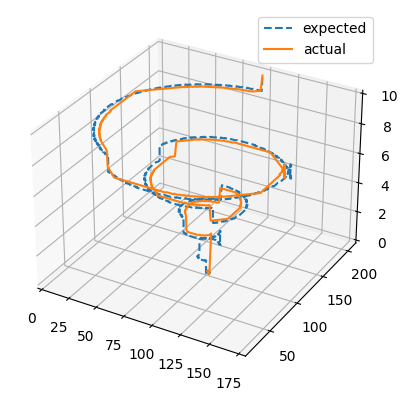

In [4]:
x_int = x.astype(int)
y_int = y.astype(int)
z_int = z.astype(int)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(x_int, y_int, z_int, label='expected',linestyle='--')
ax.plot(c_x,c_y,c_z, label='actual')
ax.legend()

In [5]:
from scipy.interpolate import UnivariateSpline

def smooth_3d_array(x,y,z,num=None,**kwargs):
    if num is None:
        num = len(x)
    w = np.arange(0,len(x),1)
    sx = UnivariateSpline(w,x,**kwargs)
    sy = UnivariateSpline(w,y,**kwargs)
    sz = UnivariateSpline(w,z,**kwargs)
    wnew = np.linspace(0,len(c_x),num)
    return sx(wnew),sy(wnew),sz(wnew)


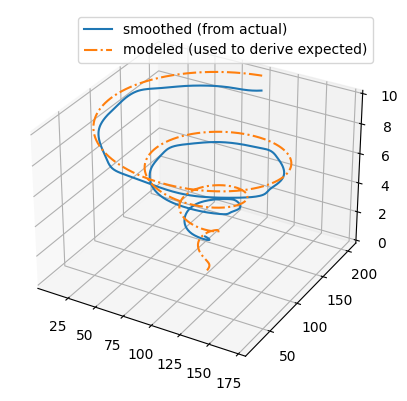

In [6]:
smothing_factor = 100
# original paper used cubic smoothing spline, not the below.
s_x,s_y,s_z = smooth_3d_array(c_x,c_y,c_z,s=smothing_factor)
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(s_x,s_y,s_z, label='smoothed (from actual)')
ax.plot(x, y, z, label='modeled (used to derive expected)',linestyle='-.')
ax.legend()
plt.show()

In [7]:
from extract_slice import extract_slice
from scipy.ndimage import distance_transform_edt

In [8]:
print(np.min(img),np.max(img),img.shape)
bsfield = distance_transform_edt(img)
img_obj = sitk.GetImageFromArray(np.moveaxis(img,-1,0).astype(float))
img_obj.SetOrigin((0,0,0))
img_obj.SetDirection((1,0,0,0,1,0,0,0,1))
img_obj.SetSpacing((1,1,1))
gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
gaussian.SetSigma(2)
img_obj = gaussian.Execute(img_obj)
tmp = sitk.GetArrayFromImage(img_obj)
print(np.min(tmp),np.max(tmp),img_obj.GetSize())

False True (256, 256, 15)
-0.0015322577 0.9913462 (256, 256, 15)


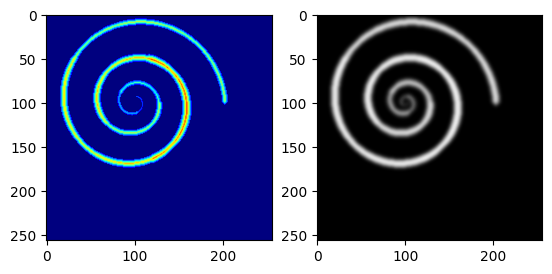

In [9]:
idx = 7
plt.subplot(121)
plt.imshow(bsfield[:,:,idx].squeeze(),cmap='jet',vmin=0,vmax=5)
plt.subplot(122)
plt.imshow(tmp[idx,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)

366,(159.0, 119.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
367,(158.0, 120.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
368,(158.0, 121.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
369,(157.0, 122.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
370,(157.0, 123.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
371,(156.0, 124.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
372,(156.0, 125.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
373,(155.0, 126.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
374,(155.0, 127.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
375,(154.0, 128.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
376,(153.0, 129.0, 7.0),[-2.  4.  0.],(512, 512, 1),1.0
377,(153.0, 130.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
378,(152.0, 131.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
379,(151.0, 132.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
380,(151.0, 133.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
381,(150.0, 134.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
382,(149.0, 135.0, 7.0),[-3.  4.  0.],(512, 512, 1),1.0
383,(148.0, 136.0, 7.0),[-3.  4.  0.],(512, 512,

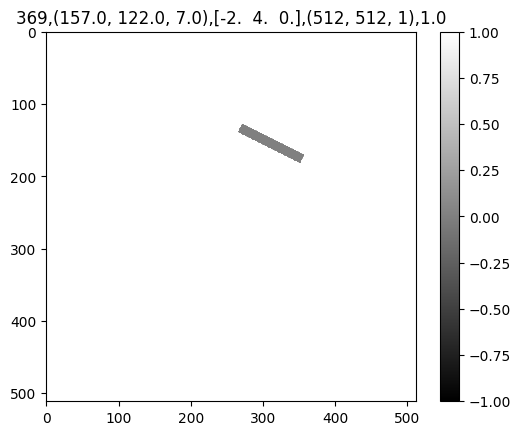

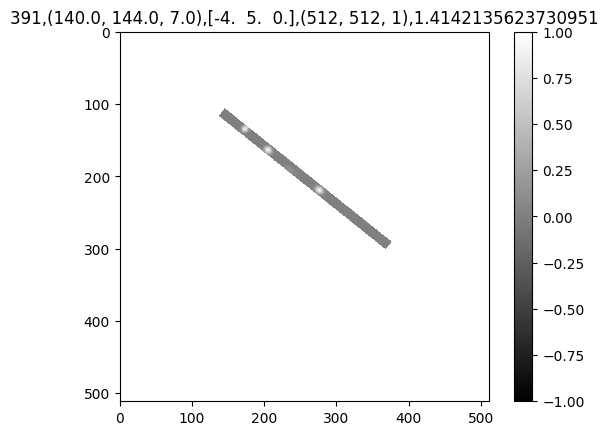

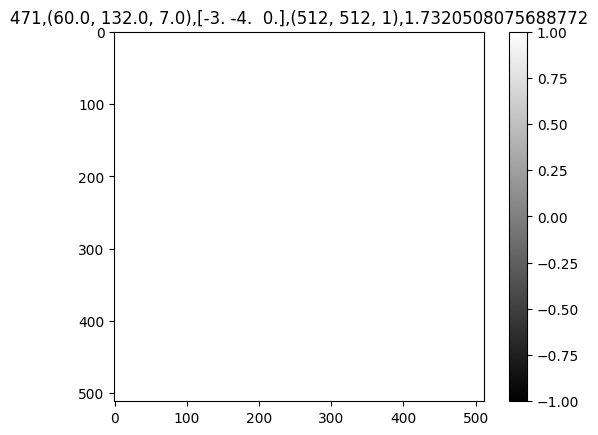

In [16]:

for n,idx in enumerate(range(len(s_z))):

    slice_center = int(c_x[idx  ]),int(c_y[idx  ]),int(c_z[idx  ])
    if slice_center[2] != 7:
        continue
    before_point = int(s_x[idx-2]),int(s_y[idx-2]),int(s_z[idx-2])
    after_point  = int(s_x[idx+2]),int(s_y[idx+2]),int(s_z[idx+2])

    appx_radius = bsfield[slice_center[0],slice_center[1],slice_center[2]]
    
    slice_center = img_obj.TransformContinuousIndexToPhysicalPoint(slice_center)
    before_point = img_obj.TransformContinuousIndexToPhysicalPoint(before_point)
    after_point = img_obj.TransformContinuousIndexToPhysicalPoint(after_point)
    slice_normal = np.array(after_point)-np.array(before_point)
    slice_spacing = (1,1,1) # mm
    slice_size = (512,512,1)#(int(appx_radius)*10,int(appx_radius)*10,1) # voxel
    is_label = False
    
    slice_obj = extract_slice(img_obj,slice_center,slice_normal,slice_spacing,slice_size,is_label)    
    slice_arr = sitk.GetArrayFromImage(slice_obj)
    title = f"{idx},{slice_center},{slice_normal},{slice_size},{appx_radius}"
    print(title)
    if idx in [369,391,471]:
        plt.figure(idx)
        plt.title(title)
        plt.imshow(slice_arr.squeeze(),cmap='gray',vmin=-1,vmax=1)
        plt.colorbar()